Import Required Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier, plot_importance

import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")


Load the Dataset


In [4]:
# Load the Telco churn dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Display shape and a preview
print("Shape of dataset:", df.shape)
display(df.head())


Shape of dataset: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Initial Data Cleaning

In [5]:
# Convert TotalCharges to numeric and handle errors
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'].replace(" ", np.nan), errors='coerce')

# Check missing values
print("Missing values:\n", df.isnull().sum())

# Fill missing TotalCharges with median
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Drop customerID (not useful for prediction)
df.drop('customerID', axis=1, inplace=True)


Missing values:
 customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


Basic Statistics

In [6]:
# Quick overview of numerical features
display(df.describe())


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928
std,0.368612,24.559481,30.090047,2265.270398
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


Encode Categorical Variables

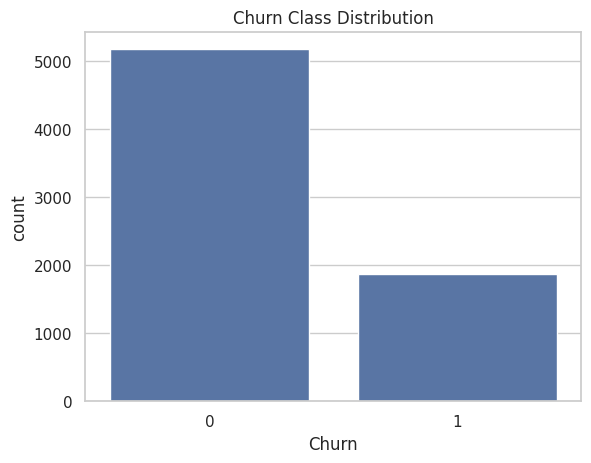

In [7]:
# Convert binary columns from Yes/No to 1/0
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

# Encode target column
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Show churn class distribution
sns.countplot(x='Churn', data=df)
plt.title("Churn Class Distribution")
plt.show()

# Encode other categorical columns using label encoding
multi_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
              'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
              'Contract', 'PaymentMethod', 'gender']

le = LabelEncoder()
for col in multi_cols:
    df[col] = le.fit_transform(df[col])


Correlation Analysis

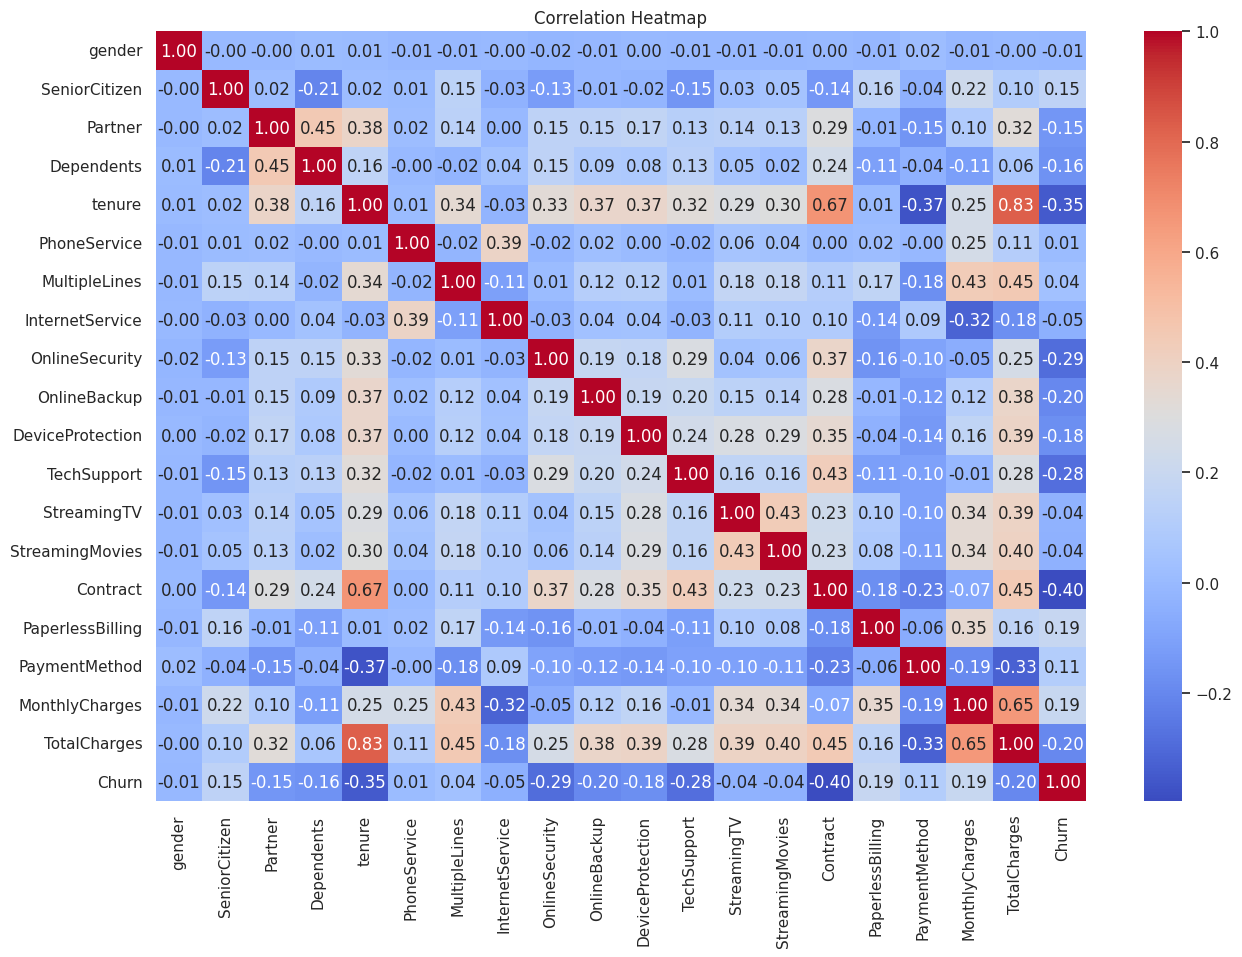

In [8]:
# Visualize correlation between features
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


Feature Engineering

In [9]:
# Calculate average monthly charges over tenure
df['AvgChargesPerMonth'] = df['TotalCharges'] / df['tenure']
df['AvgChargesPerMonth'].replace([np.inf, -np.inf], 0, inplace=True)
df['AvgChargesPerMonth'].fillna(0, inplace=True)

# Count how many services a customer has
service_cols = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
                'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df['NumServices'] = df[service_cols].apply(lambda x: sum(x != 0), axis=1)

# Add a feature to flag long-term customers
df['IsLongTerm'] = (df['tenure'] > 24).astype(int)

# Group tenure into bins
df['TenureGroup'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 72], labels=['0-12', '13-24', '25-48', '49-72'])
df['TenureGroup'] = le.fit_transform(df['TenureGroup'])


Visual Exploration of Features vs. Churn

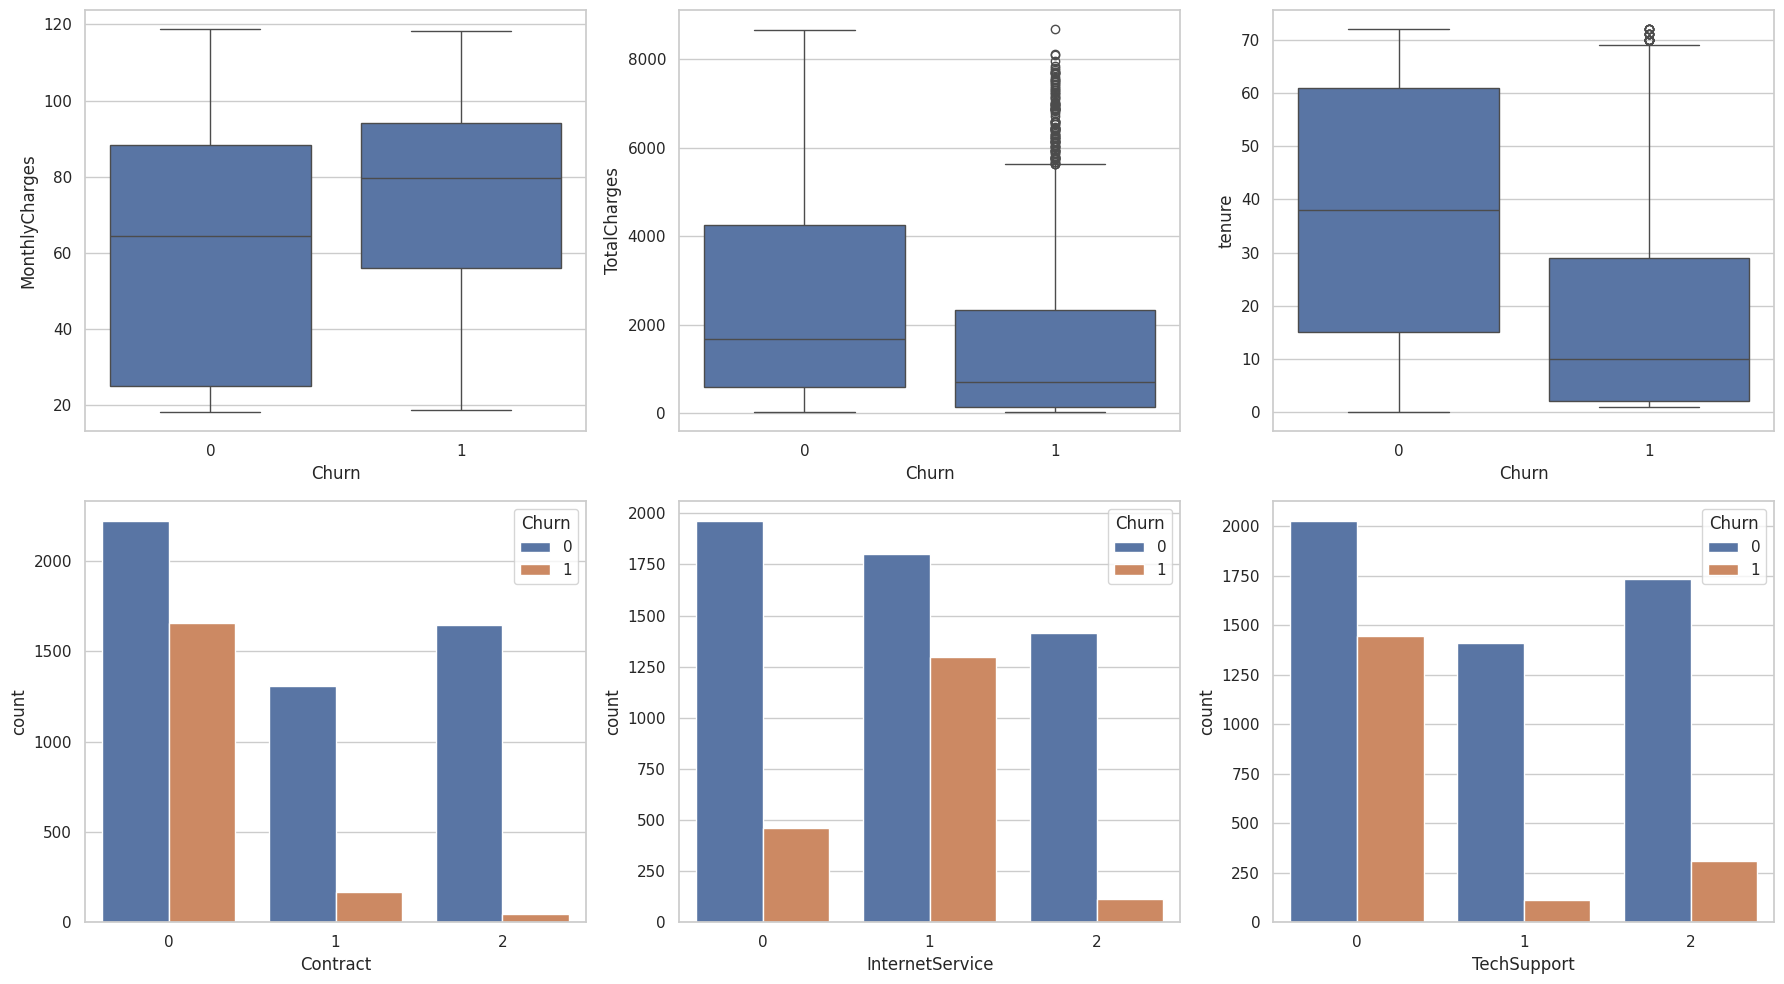

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Distribution of charges and tenure by churn status
sns.boxplot(data=df, x='Churn', y='MonthlyCharges', ax=axes[0, 0])
sns.boxplot(data=df, x='Churn', y='TotalCharges', ax=axes[0, 1])
sns.boxplot(data=df, x='Churn', y='tenure', ax=axes[0, 2])

# Categorical features vs. churn
sns.countplot(data=df, x='Contract', hue='Churn', ax=axes[1, 0])
sns.countplot(data=df, x='InternetService', hue='Churn', ax=axes[1, 1])
sns.countplot(data=df, x='TechSupport', hue='Churn', ax=axes[1, 2])

plt.tight_layout()
plt.show()


Prepare Data for Modeling

In [11]:
# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Scale numerical features for better model performance
scaler = StandardScaler()
X[['tenure', 'MonthlyCharges', 'TotalCharges', 'AvgChargesPerMonth']] = scaler.fit_transform(
    X[['tenure', 'MonthlyCharges', 'TotalCharges', 'AvgChargesPerMonth']]
)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


Train the XGBoost Classifier

In [12]:
# Train an XGBoost model (a powerful tree-based algorithm)
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)


Evaluate Model Performance

Accuracy Score: 0.7856635911994322

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      1035
           1       0.61      0.53      0.57       374

    accuracy                           0.79      1409
   macro avg       0.72      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



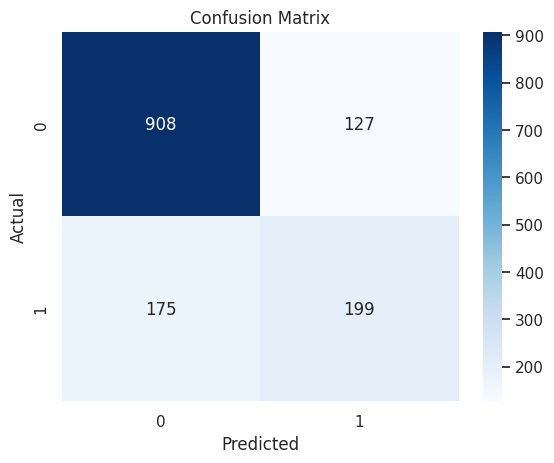

In [13]:
# Print accuracy
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# Detailed classification metrics
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix heatmap
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Visualize Feature Importance

<Figure size 1000x800 with 0 Axes>

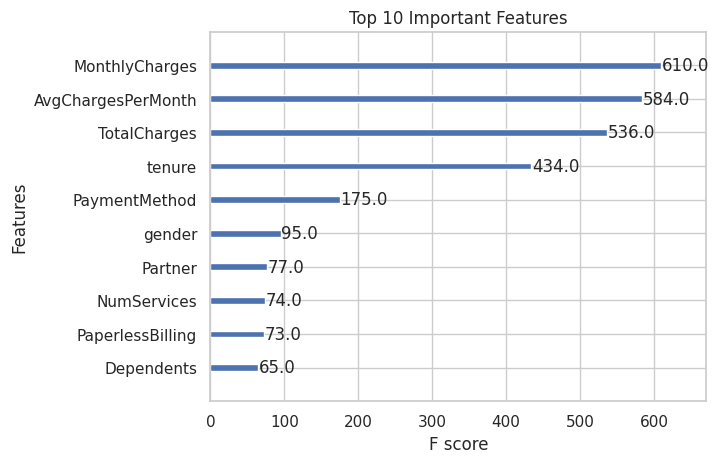

In [14]:
# Plot which features were most important to the model
plt.figure(figsize=(10, 8))
plot_importance(model, max_num_features=10)
plt.title("Top 10 Important Features")
plt.show()
